# DataLab Cup 2: CNN for Object Detection

Sao-Hsuan Lin

113062532

In [1]:
import os

# ID
# TODO: change ID to the model name or experiment name
ID = "yolov8-b3-v2"
# ID = "yolov8-b3-v3"
# ID = "yolov8-b3-x-v1"
# ID = "yolov8-dn121-v1"

# common params
# TODO: change DEVICE
DEVICE = "cuda:2"  # "cuda:i" or "cpu"
OMP_NUM_THREADS = 10
SEED = 42

# dataset params
# TODO: change the path to training data
# TRAIN_DATA_PATH = "./dataset/pascal_voc_training_data.txt"
# TRAIN_IMAGE_DIR = "./dataset/VOCdevkit_train/VOC2007/JPEGImages/"
TRAIN_DATA_PATH = "./dataset/augmented_data.txt"
TRAIN_IMAGE_DIR = "./dataset/AugmentedImage/"
# TRAIN_DATA_PATH = "./dataset/augmented_data_yolov8.txt"
# TRAIN_IMAGE_DIR = "./dataset/AugmentedImageYoloV8/"
TEST_DATA_PATH = "./dataset/pascal_voc_testing_data.txt"
TEST_IMAGE_DIR = "./dataset/VOCdevkit_test/VOC2007/JPEGImages/"

# model params I
IMAGE_SIZE = 640
BATCH_SIZE = 16
NUM_CLASSES = 20
REG_MAX = 16
MAX_OBJECTS_PER_IMAGE = 100

# model params II
# TODO: change the model size and weights
MODEL_SIZE = "m"
BOX_LOSS_WEIGHT = 7.5
CLS_LOSS_WEIGHT = 0.5
DFL_LOSS_WEIGHT = 1.5

# training params
# TODO: change the number of epochs
START_EPOCH = 0
EPOCHS = 0
# TODO: change lr
LEARNING_RATE = 1e-3
# TODO: change if freeze backbone or training all
FREEZE_BACKBONE = True

# checkpoint params
CHECKPOINT_DIR = os.path.join("./ckpts/", ID)
CHECKPOINT_NAME = "yolov8_checkpoint"

# evaluation params
OUTPUT_DIR = os.path.join("./output/", ID)
PRED_OUTPUT_PATH = os.path.join(OUTPUT_DIR, "yolo_predictions.csv")
EVAL_OUTPUT_PATH = os.path.join(OUTPUT_DIR, "yolo_eval_results.csv")

In [2]:
import os
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    gpus = torch.cuda.device_count()
    print(f"Number of GPUs: {gpus}")
    device = torch.device(DEVICE)
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")
print(f"Device: {device}")

os.environ["OMP_NUM_THREADS"] = str(OMP_NUM_THREADS)
torch.manual_seed(SEED)

Number of GPUs: 4
Device: cuda:2


In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
from models.yolov8.layers import (
    YoloV8WithResNet,
    YoloV8WithEfficientNetB3,
    YoloV8WithDenseNet121,
)

model_cls = YoloV8WithEfficientNetB3
if MODEL_SIZE == "n":
    model = model_cls.get_yolo_v8_n(
        num_classes=NUM_CLASSES,
        reg_max=REG_MAX,
        pred_max=MAX_OBJECTS_PER_IMAGE,
    )
elif MODEL_SIZE == "m":
    model = model_cls.get_yolo_v8_m(
        num_classes=NUM_CLASSES,
        reg_max=REG_MAX,
        pred_max=MAX_OBJECTS_PER_IMAGE,
    )
elif MODEL_SIZE == "x":
    model = model_cls.get_yolo_v8_x(
        num_classes=NUM_CLASSES,
        reg_max=REG_MAX,
        pred_max=MAX_OBJECTS_PER_IMAGE,
    )
model = model.to(device)

trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad
)
total_params = sum(p.numel() for p in model.parameters())
print(
    "Trainable parameters: {}\nTotal parameters: {}\nRatio: {:5.3f}".format(
        trainable_params,
        total_params,
        trainable_params / total_params,
    )
)

Trainable parameters: 25406076
Total parameters: 35509428
Ratio: 0.715


In [5]:
from torch.utils.data import DataLoader, random_split
from models.yolov8.data import (
    TrainDatasetGenerator,
    train_collate_fn,
)


def create_data_loader(
    data_path,
    image_dir,
    batch_size,
    image_size,
    shuffle=True,
    num_workers=8,
    pin_memory=False,
    drop_last=False,
    device: str = "",
):
    dataset = TrainDatasetGenerator(
        data_path,
        image_dir,
        image_size,
    )
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=pin_memory,
        drop_last=drop_last,
        pin_memory_device=device,
        collate_fn=train_collate_fn,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory,
        drop_last=drop_last,
        pin_memory_device=device,
        collate_fn=train_collate_fn,
    )
    return train_loader, val_loader

## Training

In [6]:
import os
import math
import time
import numpy as np
import torch
from torch import optim
from torch.optim import lr_scheduler
from datetime import datetime
from models.yolov8.layers import YoloV8, YoloV8Loss
from utils.training import load_checkpoint, save_checkpoint


# Training step function
def train_step(
    model: YoloV8,
    optimizer: optim.Optimizer,
    images: torch.Tensor,
    labels: torch.Tensor,
):
    model.train()  # Set model to training mode
    optimizer.zero_grad()  # Zero out gradients
    outputs = model(images)  # Forward pass
    loss = yolo_loss(outputs, labels)  # Compute loss
    loss_metric = loss.item()
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights
    return loss_metric


def val_step(model: YoloV8, images: torch.Tensor, labels: torch.Tensor):
    with torch.no_grad():
        model.eval()  # Set model to evaluation mode
        outputs = model(images)
        loss = yolo_loss(outputs, labels)
        loss_metric = loss.item()
    return loss_metric


# Directory for saving checkpoints
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

train_loader, val_loader = create_data_loader(
    TRAIN_DATA_PATH,
    TRAIN_IMAGE_DIR,
    BATCH_SIZE,
    IMAGE_SIZE,
)

yolo_loss = None
optimizer = None
scheduler = None

if EPOCHS > 0:
    # Initialize objects if need training
    yolo_loss = YoloV8Loss(
        model,
        box_loss_weight=BOX_LOSS_WEIGHT,
        cls_loss_weight=CLS_LOSS_WEIGHT,
        dfl_loss_weight=DFL_LOSS_WEIGHT,
    ).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

    # Load checkpoint if available
    if START_EPOCH > 0:
        load_checkpoint(
            model, CHECKPOINT_DIR, CHECKPOINT_NAME, optimizer, START_EPOCH
        )

    # Force set lr
    optimizer.param_groups[0]["lr"] = LEARNING_RATE

    # Freeze/Unfreeze backbone
    if FREEZE_BACKBONE:
        model.freeze_backbone()
    else:
        model.unfreeze_backbone()


error_breaking = False

# Training loop
print(f"{datetime.now()}, start training.")
for epoch in range(START_EPOCH, EPOCHS + START_EPOCH):
    start_ts = time.perf_counter()
    loss_metric_list = []
    loss_detail_list = []
    val_loss_metric_list = []

    for idx, (images, labels) in enumerate(train_loader):
        images, labels = (
            images.to(device),
            labels.to(device),
        )
        loss_metric = train_step(model, optimizer, images, labels)
        loss_metric_list.append(loss_metric)
        loss_detail_list.append(yolo_loss._prev_loss.cpu().detach().numpy())

        if (
            math.isnan(loss_metric)
            or math.isinf(loss_metric)
            or loss_metric < 0
            or (yolo_loss._prev_loss < 0).any()
        ):
            print("Loss is {:.4f}, stop training.".format(loss_metric))
            error_breaking = True
            break

        if idx % 100 == 0:
            lr = scheduler.get_lr()[0]
            print(
                "epoch {:3d}/{:3d}, batch: {:4d}/{:4d}, loss {:10.4f} [{:3f}, {:3f}, {:3f}], lr {:10.4e}".format(
                    epoch + 1,
                    EPOCHS + START_EPOCH,
                    idx + 1,
                    len(train_loader),
                    loss_metric,
                    yolo_loss._prev_loss[0],
                    yolo_loss._prev_loss[1],
                    yolo_loss._prev_loss[2],
                    lr,
                )
            )

    if error_breaking:
        break

    # Scheduler step after each epoch
    # scheduler.step()

    for idx, (images, labels) in enumerate(val_loader):
        images, labels = (
            images.to(device),
            labels.to(device),
        )
        val_loss_metric = val_step(model, images, labels)
        val_loss_metric_list.append(val_loss_metric)

    # Print info
    avg_train_loss = sum(loss_metric_list) / len(loss_metric_list)
    ave_train_loss_detail = np.mean(loss_detail_list, axis=0)
    avg_val_loss = sum(val_loss_metric_list) / len(val_loss_metric_list)
    lr = scheduler.get_last_lr()[0]
    print(
        "epoch {:3d}/{:3d}, train loss {:10.4f}, {}, val loss {:10.4f}, lr {:10.4e}, time {:.2f}s".format(
            epoch + 1,
            EPOCHS + START_EPOCH,
            avg_train_loss,
            ave_train_loss_detail,
            avg_val_loss,
            lr,
            time.perf_counter() - start_ts,
        )
    )

    # Save checkpoint
    save_checkpoint(
        epoch + 1, model, optimizer, CHECKPOINT_DIR, CHECKPOINT_NAME
    )

2024-11-15 02:52:52.579298, start training.


## Predict Test data

In [7]:
# Load model from checkpoint
load_checkpoint(model, CHECKPOINT_DIR, CHECKPOINT_NAME, epoch=None)

Loaded checkpoint from ./ckpts/yolov8-b3-v2/yolov8_checkpoint_010.pt


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:02<00:00,  9.30it/s]


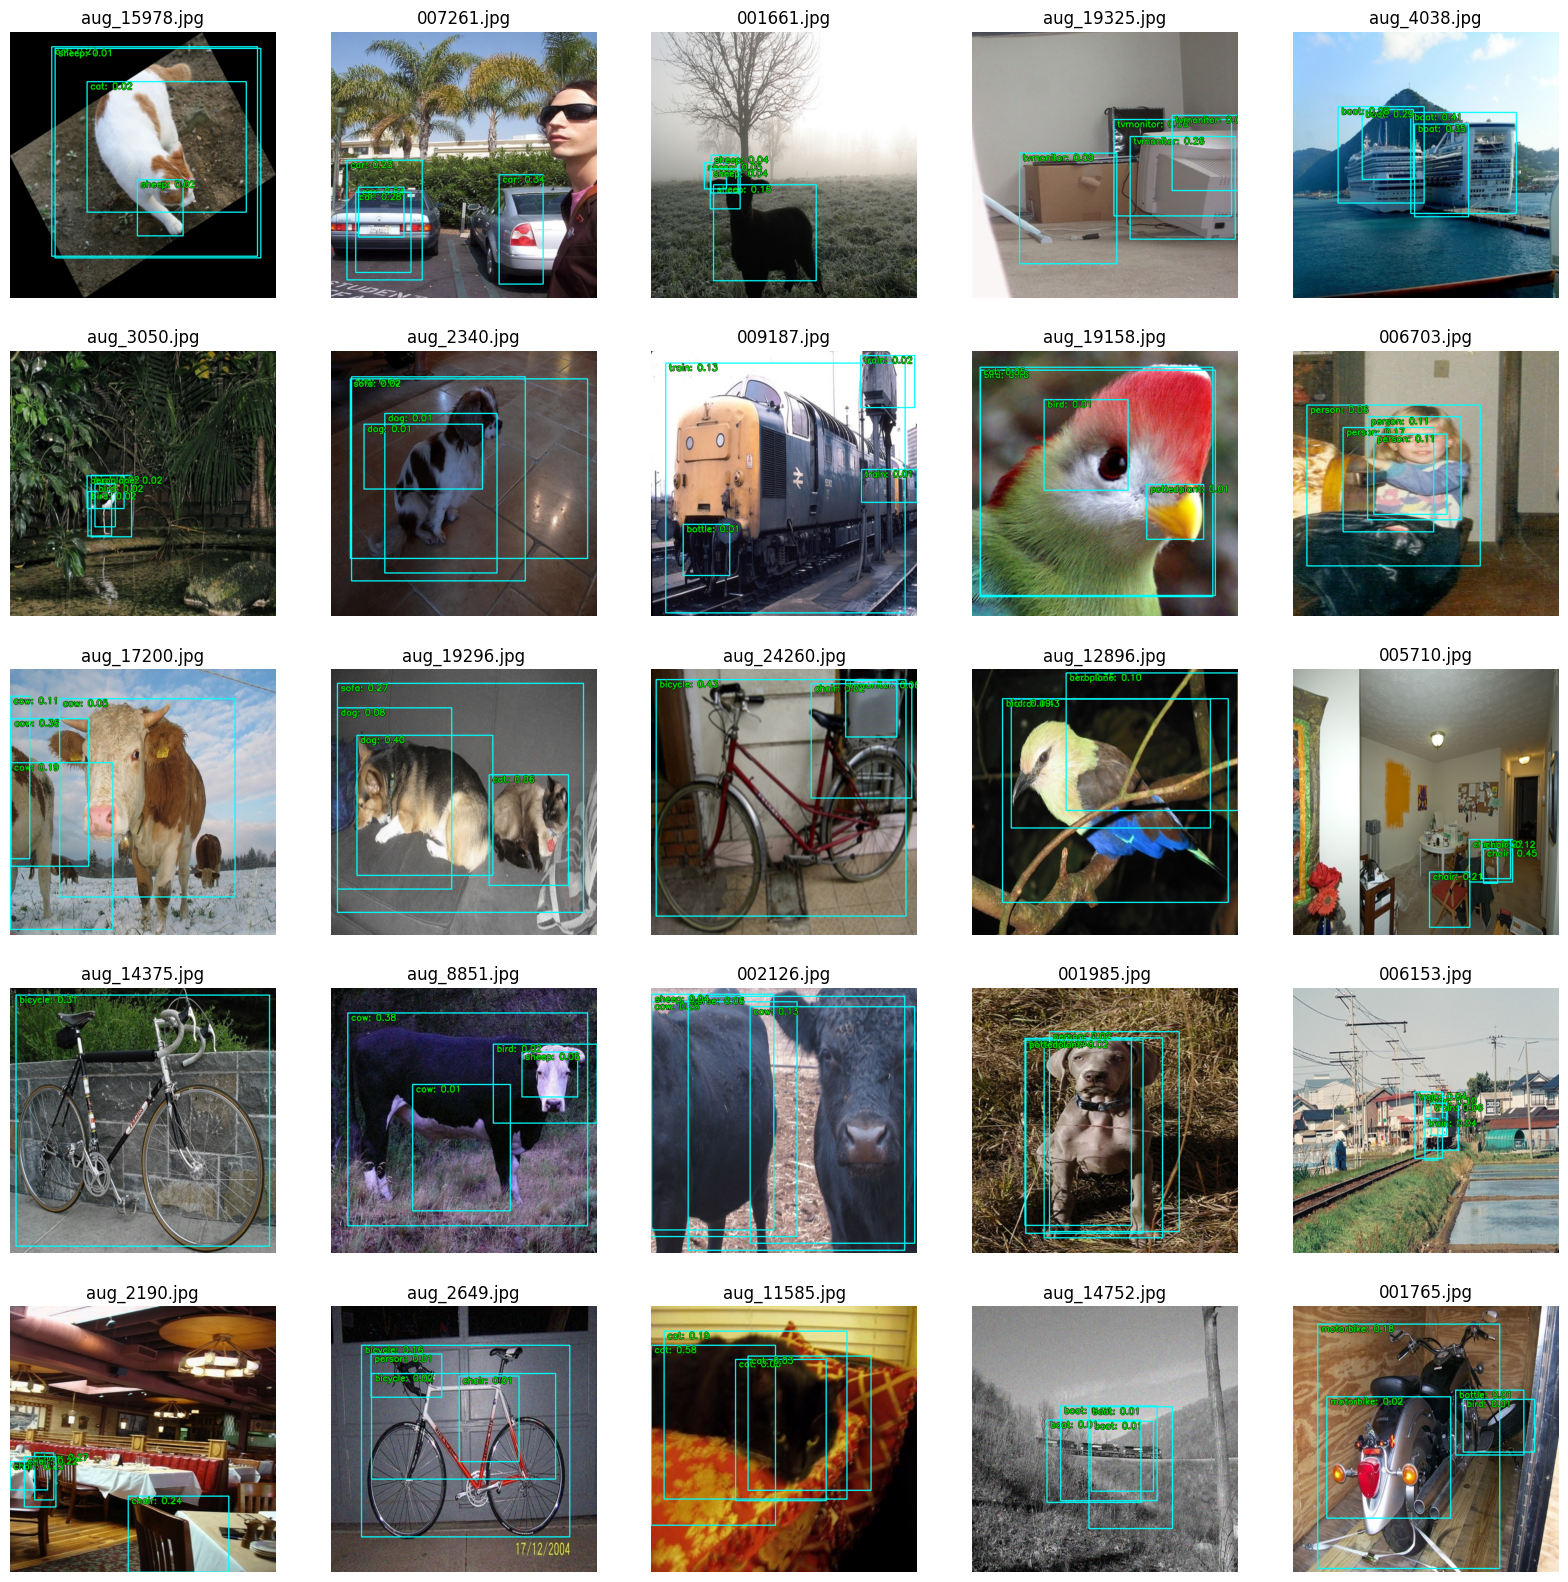

100%|██████████| 25/25 [00:01<00:00, 14.47it/s]


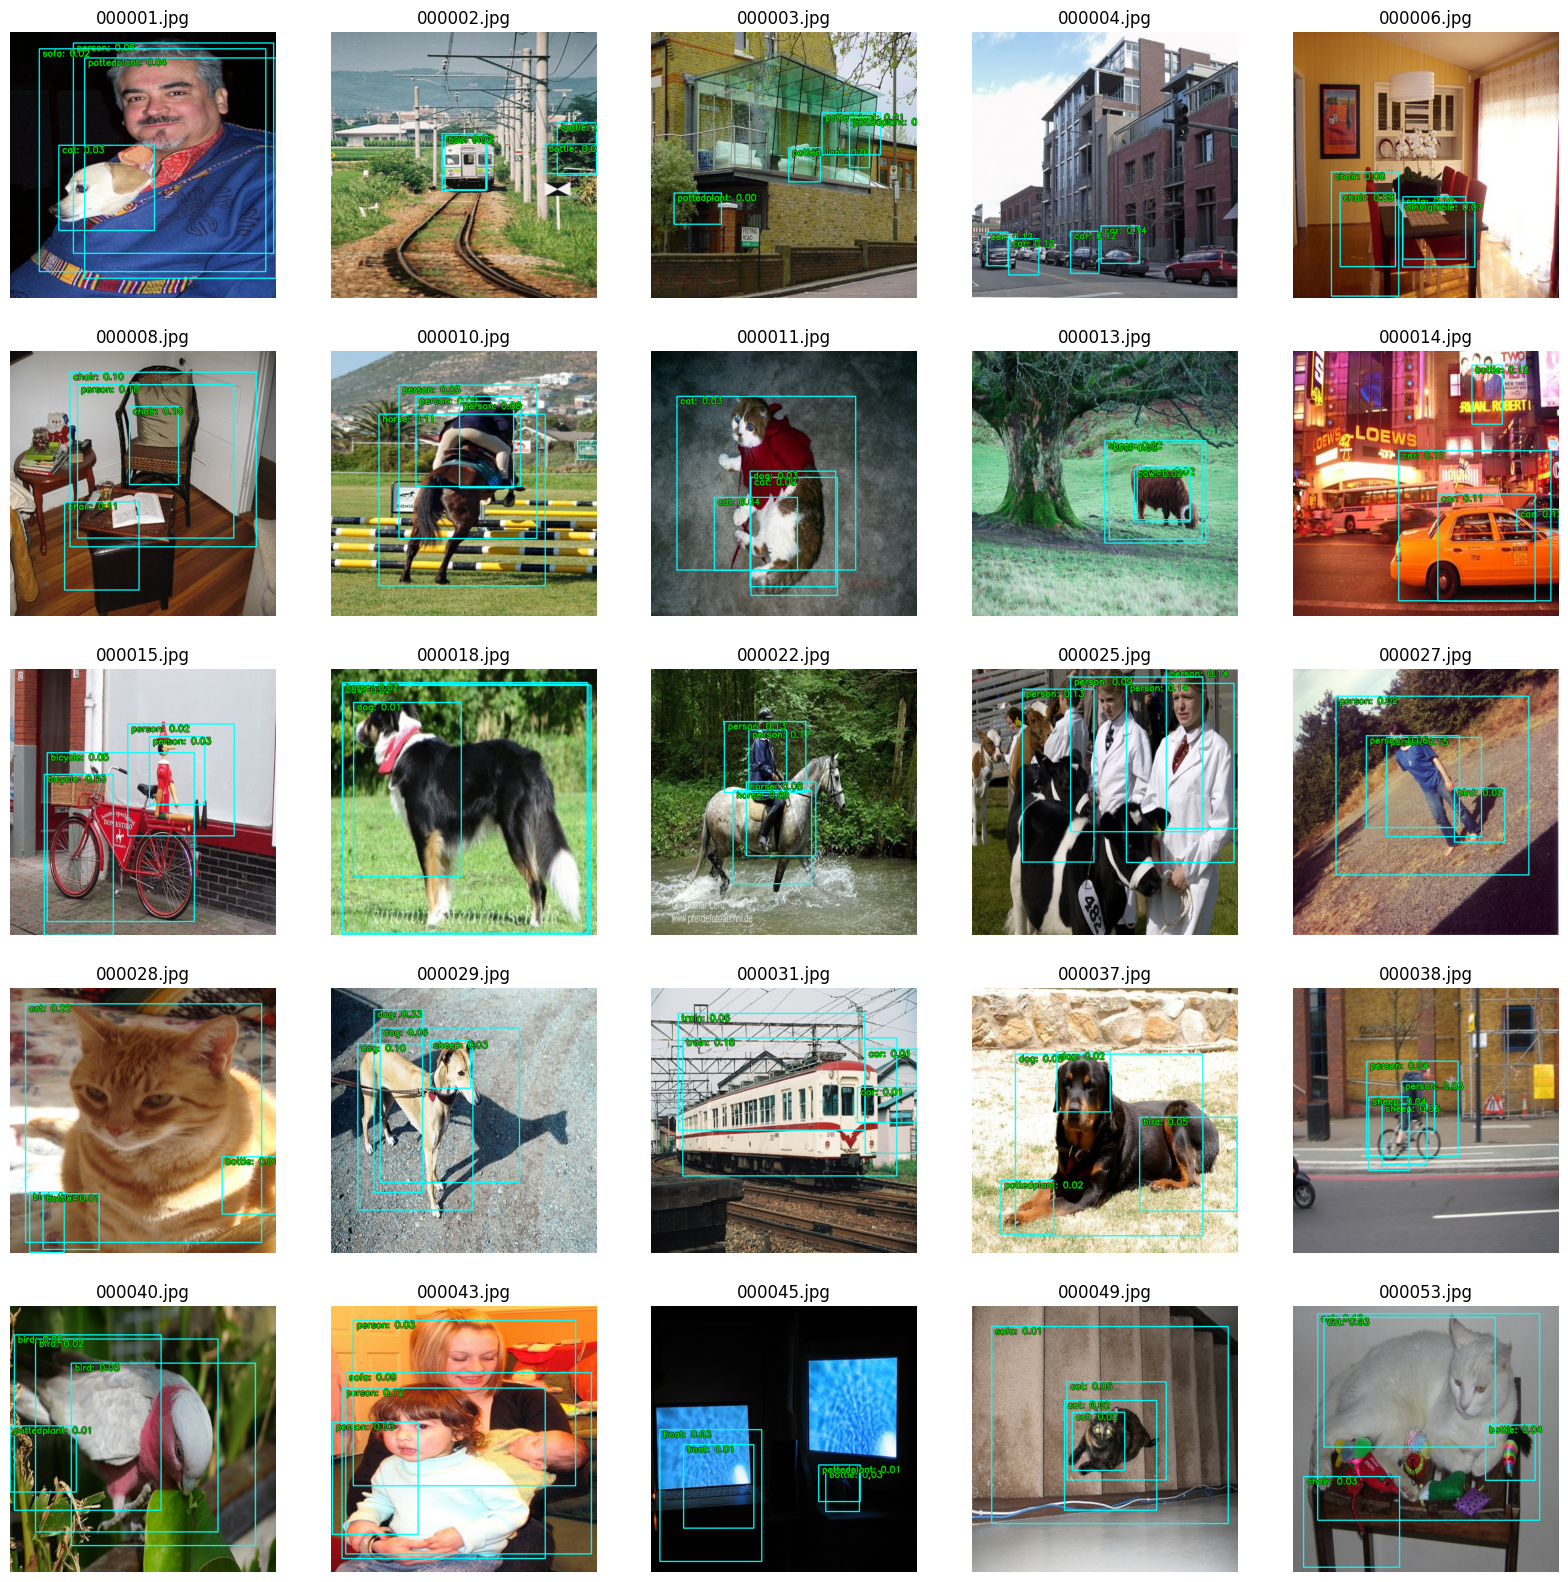

In [8]:
import random
from IPython import get_ipython
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.data import CLASS_NAMES
from models.yolov8.layers import YoloV8
from models.yolov8.utils import process_outputs


def predict_draw(image_path, model: YoloV8):
    np_img = cv2.imread(image_path)
    np_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
    np_img = cv2.cvtColor(np_img, cv2.COLOR_BGR2RGB)
    resized_img = np_img
    np_img = np_img.astype(np.float32)
    np_img = np_img / 255.0 * 2 - 1
    np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))
    np_img = np.transpose(np_img, (0, 3, 1, 2))

    with torch.no_grad():
        model.eval()
        y_pred = (
            model.inference(torch.tensor(np_img).to(device)).cpu().detach()
        )
    bbox_list, class_list, conf_list = process_outputs(
        y_pred, IMAGE_SIZE, conf_threshold=0.0, conf_ratio=0.01
    )

    bboxes, classes, confidences = (
        bbox_list[0],
        class_list[0],
        conf_list[0],
    )
    for idx, (bbox, class_idx, conf) in enumerate(
        zip(bboxes, classes, confidences)
    ):
        if idx >= 4:
            break
        xmin, ymin, xmax, ymax = bbox
        cv2.rectangle(
            resized_img,
            (int(xmin), int(ymin)),
            (int(xmax), int(ymax)),
            (0, 255, 255),
            2,
        )
        txt = f"{CLASS_NAMES[class_idx]}: {conf:.2f}"
        cv2.putText(
            resized_img,
            txt,
            (int(xmin) + 8, int(ymin) + 18),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            (0, 0, 0),
            3,
            cv2.LINE_8,
        )
        cv2.putText(
            resized_img,
            txt,
            (int(xmin) + 8, int(ymin) + 18),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            (0, 220, 0),
            2,
            cv2.LINE_8,
        )
    return resized_img


def visualize(data_path, image_dir, model, shuffle=False):
    # Retrieve image names
    image_names = []
    with open(data_path, "r") as f:
        for line in f:
            image_names.append(line.strip().split(" ")[0])
    image_names = (
        random.sample(image_names, 25) if shuffle else image_names[:25]
    )

    results = []
    for image_name in tqdm(image_names):
        image_path = os.path.join(image_dir, image_name)
        image = predict_draw(image_path, model)
        results.append((image, image_name))

    plt.figure(figsize=(20, 20))
    for i, (img, title) in enumerate(results):
        plt.subplot(5, 5, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(title)
    plt.show()


ipy = get_ipython()
if ipy is not None:
    ipy.run_line_magic("matplotlib", "inline")

    random.seed(SEED)
    visualize(TRAIN_DATA_PATH, TRAIN_IMAGE_DIR, model, shuffle=True)
    visualize(TEST_DATA_PATH, TEST_IMAGE_DIR, model)

    with open(TEST_DATA_PATH, "r") as f:
        test_data = f.readlines()

    # image_name = random.choice(test_data).strip().split(" ")[0]
    # image_path = os.path.join(TEST_IMAGE_DIR, image_name)
    # image_path = "./dataset/VOCdevkit_test/VOC2007/JPEGImages/000002.jpg"
    # print(f"Read image: {image_path}")
    # image = predict_draw(image_path, model)
    # plt.imshow(image)
    # plt.show()

In [9]:
import os
from tqdm import tqdm
from torch.utils.data import DataLoader
from models.yolov8.layers import YoloV8
from models.yolov8.data import TestDatasetGenerator
from utils.evaluate import evaluate
from compute_score import compute_score


def predict(
    model: YoloV8,
    test_data_path: str,
    test_image_dir: str,
    image_size: int,
    batch_size: int,
    pred_output_path: str,
    conf_threshold: float = 0.0,
    conf_ratio: float = 0.4,
):
    # Test data loader
    data_loader = DataLoader(
        TestDatasetGenerator(test_data_path, test_image_dir, image_size),
        batch_size=batch_size,
        shuffle=False,
        num_workers=8,
        pin_memory=False,
    )

    # Test the model
    # Output format: image_name {xmin_i ymin_i xmax_i ymax_i class_i confidence_score} (repeat number of objects times)
    if not os.path.exists(os.path.dirname(pred_output_path)):
        os.makedirs(os.path.dirname(pred_output_path))
    with open(pred_output_path, "w") as output_file:
        for image_names, images, image_heights, image_widths in tqdm(
            data_loader
        ):
            images, image_heights, image_widths = (
                images.to(device),
                image_heights.to(device),
                image_widths.to(device),
            )
            with torch.no_grad():
                model.eval()
                outputs = model.inference(images).cpu().detach()
            bbox_list, class_list, conf_list = process_outputs(
                outputs,
                IMAGE_SIZE,
                conf_threshold=conf_threshold,
                conf_ratio=conf_ratio,
            )
            for batch_idx in range(images.size(0)):
                answers = []
                bboxes, classes, confidences = (
                    bbox_list[batch_idx],
                    class_list[batch_idx],
                    conf_list[batch_idx],
                )
                for bbox, class_idx, conf in zip(bboxes, classes, confidences):
                    xmin, ymin, xmax, ymax = bbox
                    xmin, ymin, xmax, ymax = (
                        xmin * (image_widths[batch_idx] / IMAGE_SIZE),
                        ymin * (image_heights[batch_idx] / IMAGE_SIZE),
                        xmax * (image_widths[batch_idx] / IMAGE_SIZE),
                        ymax * (image_heights[batch_idx] / IMAGE_SIZE),
                    )
                    answers.append(
                        "%d %d %d %d %d %f"
                        % (xmin, ymin, xmax, ymax, class_idx, conf)
                    )
                output_file.write(
                    image_names[batch_idx] + " " + " ".join(answers) + "\n"
                )


for conf_ratio in np.arange(0.1, 0.6, 0.1):
    print("Confidence ratio:", conf_ratio)
    PRED_OUTPUT_PATH = os.path.join(
        OUTPUT_DIR, f"yolo_predictions_{conf_ratio:.1f}.csv"
    )
    predict(
        model,
        TEST_DATA_PATH,
        TEST_IMAGE_DIR,
        IMAGE_SIZE,
        BATCH_SIZE,
        PRED_OUTPUT_PATH,
        conf_ratio=conf_ratio,
    )
    evaluate(PRED_OUTPUT_PATH, EVAL_OUTPUT_PATH)
    print("Predict saved to", PRED_OUTPUT_PATH)
    print("Evaluation saved to", EVAL_OUTPUT_PATH)
    print("Score {:.4f}".format(compute_score(EVAL_OUTPUT_PATH)))
    print()

Confidence ratio: 0.1


  0%|          | 0/307 [00:00<?, ?it/s]

100%|██████████| 307/307 [01:51<00:00,  2.75it/s]


End Evalutation
Predict saved to ./output/yolov8-b3-v2/yolo_predictions_0.1.csv
Evaluation saved to ./output/yolov8-b3-v2/yolo_eval_results.csv
Score 0.4199

Confidence ratio: 0.2


100%|██████████| 307/307 [01:29<00:00,  3.45it/s]


End Evalutation
Predict saved to ./output/yolov8-b3-v2/yolo_predictions_0.2.csv
Evaluation saved to ./output/yolov8-b3-v2/yolo_eval_results.csv
Score 0.4199

Confidence ratio: 0.30000000000000004


100%|██████████| 307/307 [01:20<00:00,  3.81it/s]


End Evalutation
Predict saved to ./output/yolov8-b3-v2/yolo_predictions_0.3.csv
Evaluation saved to ./output/yolov8-b3-v2/yolo_eval_results.csv
Score 0.4240

Confidence ratio: 0.4


100%|██████████| 307/307 [01:14<00:00,  4.13it/s]


End Evalutation
Predict saved to ./output/yolov8-b3-v2/yolo_predictions_0.4.csv
Evaluation saved to ./output/yolov8-b3-v2/yolo_eval_results.csv
Score 0.4327

Confidence ratio: 0.5


100%|██████████| 307/307 [01:11<00:00,  4.31it/s]


End Evalutation
Predict saved to ./output/yolov8-b3-v2/yolo_predictions_0.5.csv
Evaluation saved to ./output/yolov8-b3-v2/yolo_eval_results.csv
Score 0.4415



In [10]:
for epoch in range(1, 11):
    # Load model from checkpoint
    load_checkpoint(model, CHECKPOINT_DIR, CHECKPOINT_NAME, epoch=epoch)

    conf_ratio = 0.1
    print("Confidence ratio:", conf_ratio)
    PRED_OUTPUT_PATH = os.path.join(
        OUTPUT_DIR, f"yolo_predictions_{conf_ratio:.1f}.csv"
    )
    predict(
        model,
        TEST_DATA_PATH,
        TEST_IMAGE_DIR,
        IMAGE_SIZE,
        BATCH_SIZE,
        PRED_OUTPUT_PATH,
        conf_ratio=conf_ratio,
    )
    evaluate(PRED_OUTPUT_PATH, EVAL_OUTPUT_PATH)
    print("Evaluation saved to", EVAL_OUTPUT_PATH)
    print("Score {:.4f}".format(compute_score(EVAL_OUTPUT_PATH)))
    print()

Loaded checkpoint from ./ckpts/yolov8-b3-v2/yolov8_checkpoint_001.pt
Confidence ratio: 0.1


100%|██████████| 307/307 [02:25<00:00,  2.12it/s]


End Evalutation
Evaluation saved to ./output/yolov8-b3-v2/yolo_eval_results.csv
Score 0.6919

Loaded checkpoint from ./ckpts/yolov8-b3-v2/yolov8_checkpoint_002.pt
Confidence ratio: 0.1


100%|██████████| 307/307 [02:13<00:00,  2.30it/s]


End Evalutation
Evaluation saved to ./output/yolov8-b3-v2/yolo_eval_results.csv
Score 0.6080

Loaded checkpoint from ./ckpts/yolov8-b3-v2/yolov8_checkpoint_003.pt
Confidence ratio: 0.1


100%|██████████| 307/307 [01:58<00:00,  2.58it/s]


End Evalutation
Evaluation saved to ./output/yolov8-b3-v2/yolo_eval_results.csv
Score 0.5686

Loaded checkpoint from ./ckpts/yolov8-b3-v2/yolov8_checkpoint_004.pt
Confidence ratio: 0.1


100%|██████████| 307/307 [01:54<00:00,  2.69it/s]


End Evalutation
Evaluation saved to ./output/yolov8-b3-v2/yolo_eval_results.csv
Score 0.5024

Loaded checkpoint from ./ckpts/yolov8-b3-v2/yolov8_checkpoint_005.pt
Confidence ratio: 0.1


100%|██████████| 307/307 [01:52<00:00,  2.72it/s]


End Evalutation
Evaluation saved to ./output/yolov8-b3-v2/yolo_eval_results.csv
Score 0.4618

Loaded checkpoint from ./ckpts/yolov8-b3-v2/yolov8_checkpoint_006.pt
Confidence ratio: 0.1


100%|██████████| 307/307 [01:46<00:00,  2.87it/s]


End Evalutation
Evaluation saved to ./output/yolov8-b3-v2/yolo_eval_results.csv
Score 0.4502

Loaded checkpoint from ./ckpts/yolov8-b3-v2/yolov8_checkpoint_007.pt
Confidence ratio: 0.1


100%|██████████| 307/307 [01:51<00:00,  2.76it/s]


End Evalutation
Evaluation saved to ./output/yolov8-b3-v2/yolo_eval_results.csv
Score 0.4546

Loaded checkpoint from ./ckpts/yolov8-b3-v2/yolov8_checkpoint_008.pt
Confidence ratio: 0.1


100%|██████████| 307/307 [02:00<00:00,  2.56it/s]


End Evalutation
Evaluation saved to ./output/yolov8-b3-v2/yolo_eval_results.csv
Score 0.4714

Loaded checkpoint from ./ckpts/yolov8-b3-v2/yolov8_checkpoint_009.pt
Confidence ratio: 0.1


100%|██████████| 307/307 [01:51<00:00,  2.74it/s]


End Evalutation
Evaluation saved to ./output/yolov8-b3-v2/yolo_eval_results.csv
Score 0.4133

Loaded checkpoint from ./ckpts/yolov8-b3-v2/yolov8_checkpoint_010.pt
Confidence ratio: 0.1


100%|██████████| 307/307 [01:49<00:00,  2.79it/s]


End Evalutation
Evaluation saved to ./output/yolov8-b3-v2/yolo_eval_results.csv
Score 0.4199

